In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline

# import sys
# !{sys.executable} -m pip install graphviz

In [2]:
#this is the point abc at which we are evaluating the derivative of d with respect to a,b,c 
#at that point
a = 2.0
b = -3.0
c = 10.0

h = 0.0001
# dd/da
d1 = a*b + c
a += h
d2 = a*b + c
#d2-d1 is how much the function is increased when we bump the specific input we interested in
#by tiny amount, and we normalize by h to get the slope
print('slope',(d2-d1)/h)
#slope is negative if we go down when we bump
print('d1', d1)
print('d2', d2)

slope -3.000000000010772
d1 4.0
d2 3.999699999999999


In [3]:
# dd/db
d1 = a*b + c
b += h
d2 = a*b + c

print('slope',(d2-d1)/h)
print('d1', d1)
print('d2', d2)

slope 2.0001000000124947
d1 3.999699999999999
d2 3.99990001


In [4]:
# dd/dc
d1 = a*b + c
c += h
d2 = a*b + c

print('slope',(d2-d1)/h)#rate of increasing d as we scale c
print('d1', d1)
print('d2', d2)

slope 0.9999999999976694
d1 3.99990001
d2 4.00000001


In [5]:
# neural networks are pretty massive mathematical expressions. we need data structures
# that maintain these structures

# connective tissue of this expression, we need to know and keep pointers about what values
# produce what other values
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data=data
        self.grad = 0.0 #0 means no effect 
        self._backward = lambda : None #by default, this func doesent do anything
        self._prev = set(_children) # for efficiency we go with set
        self._op = _op
        self.label = label
    # repr for printing the class data
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # when we create value with mul and add we will feed in the children of this value
    # we also want to know what operation has created this value
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        #our job: take out.grad and propagate it to self.grad and other.grad
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
       
        out._backward= _backward #function propagates the gradient
        return out
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
       
        out._backward= _backward
        
        return out
    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward(): #CLASS DENEYI: bu sekilde fonksiyon gecirdigimzide self ve out onceki classe mi atif yapiyor 
            self.grad += (1 - t**2) * out.grad 
            # dout/dx = dout/dout * dout/dx
        #dout/dx = 1 - t**2
        out._backward= _backward
        
        return out
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    def __rmul__(self, other): # other * self
        return self * other
    def __radd__(self, other): # other + self
        return self + other
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
b._prev


set()

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f| grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

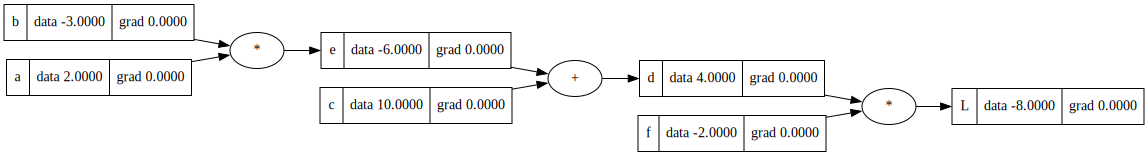

In [7]:
draw_dot(L)
# a ------> L, forward pass

In [8]:
# in backprop we will reverse and calculate the gradient of all intermediate values for L

# dL/dL = 1
# dL/df, dL/dd/ dL/de  ==> grad value in the table...

# derivative of loss func L with respect to weights of the network
# how those weights are impacting the loss function

# going to create a variable in the value class that maintains the derivative of L with 
# respect to that value, we will call it grad

#lets do backprop manually

 # what is dL/dL (if i change L by tiny amount of h, how much does L change, it changes by h)
 # = 1

# how L is sensitive to c. If we wiggle c how does that impact L, through d
# dd/dc = 1(local derivative) d = c + e
# dL/dd = -2 L = d * f (-2) (bir nevi local derivative)
# dL/dc = 1 * -2 = -2

# dd/de = 1
# dL/dd = -2
# dL/de = -2

# + node's local derivative is just 1, so derivative is just routed to both c and e. 

# There is backpropagating signal which is carrying the information of 
# derivative of L with respect to all the indermediate nodes
# We can imagine it almost like flowing backwards through the graph and + node will
# simply distribute the derivative to all the child nodes

# I know local gradient/derivative all the time 

# You can easily verify chain rule with numerical calculation by adding h to relevant variable

# dL/de = -2
# e = a * b 
# de/da = b
# de/db = a

# -2 * b = dL/da
# -2 * a = dL/db

# Gradient just give us some power because we know how to influence the final outcome
#When we nudge all the values, inputs in the direction of gradient we expect to go L up. 

# If you know the local derivative (how the input )

In [9]:
# As long as we know derivative of tanh, we can backprop through it

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

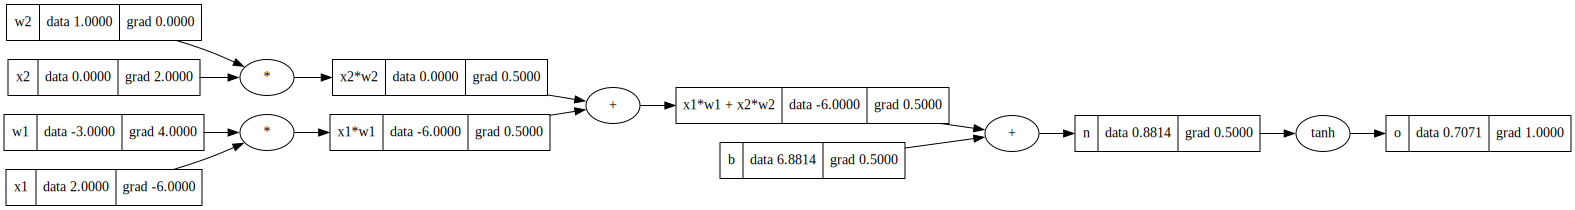

In [50]:
draw_dot(o)

In [12]:
o.backward()

In [13]:
# Implementing a topological graph
topo = []
visited = set() #Visited nodes
def build_topo(v): # v is root node, we go all through its children and we lay them out left to right
  if v not in visited:
    visited.add(v) # If a node is not visited marks it as visited
    for child in v._prev: # Iterate through all its children
      build_topo(child) # After it has gone through all the children it adds itself
    topo.append(v) # v will add itself to topo list after all of the children have been processed
build_topo(o)      #thats how this function guarentees you are gonna be in the list after once
topo               #all of your children in the list, thats the INVARIANT being maintained

# We have topological graph and now we're just calling ._backward() on all of the nodes in
# topological order 

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [14]:
o.grad = 1.0

In [15]:
o._backward()

In [16]:
n._backward()

In [17]:
b._backward() #b kok node backward yapacagi bisery yok none cagiriyo

In [18]:
x1w1x2w2._backward()

In [19]:
x1w1._backward()

In [20]:
x2w2._backward()

In [21]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

In [22]:
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [23]:
x1w1.grad = 0.5
x2w2.grad = 0.5

#Derivative is telling us: If we want output of this neuron to increase... Influence of these expressions is positive
# on the output. Both of them do positive contribution to output. => if derivative is positive? value says how much

In [24]:
#dn/dx1w1x2w2 = 1 and dn/db = 1
#do/dn = 0.5
#do/dx1w1x2w2 = 1 * 0.5 = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
# in pluses basically go itself by chain rule

In [25]:
# o = tanh(n) what is do/dn? formula: 1 - tanh(n)**2
# 1 - o**2

n.grad = 0.5 #do/dn = 0.5
1 - o.data**2

0.4999999999999999

In [26]:
#do/do = 1
o.grad = 1.0

In [27]:
#local derivative of this tanh operation is 0.5

In [28]:
# Everything has to be propagated before we continue backprop

In [29]:
# Ordering of graphs can be acvhieved by topological sort. Top. sort: laying out of a graph
# such that all the edges go only from left to right, one way. 

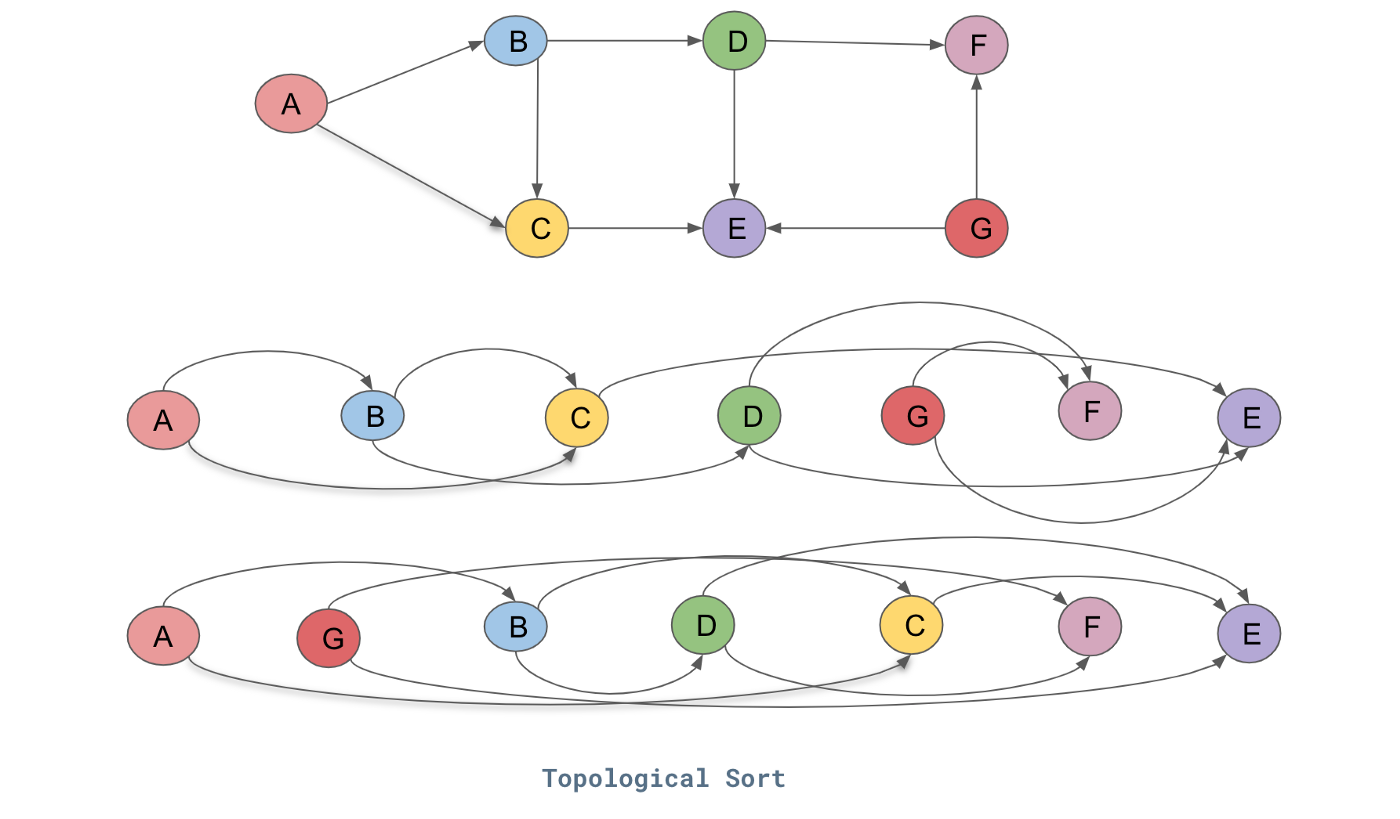

In [30]:
# To avoid overwriting when we use same Value in more than once, we cahnge _backward()s to
# +=.. We have to accumulate these gradients. Those gradients will add top of each other. 

In [31]:
# As long as you can do forward pass and backward pass of that little operation it doesnt matter
# what that little operation is, and how composite it is. If you can write the local gradient
# you can chain the gradients, you can continue to backprop, so design of what those funcs are
# completely up to you

In [32]:
# In micrograd we only have scalar values like 2.0. But in pytorch everything is based around
# tensors, tensors are just n dimensional arrays of scalars.

In [33]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  def __repr__(self):
    return f"Neuron(data={self.w + [self.b]})"

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    #return [neuron.parameters() for neuron in self.neurons] #olmaz mi? olur ama list icinde listli getirir
  def __repr__(self):
    return f"Layer(data={[neuron.parameters() for neuron in self.neurons]})" 
class MLP:
  
  def __init__(self, nin, nouts): #nouts is size of all the layers in MLP, list of nouts
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0]
# 2 dimensional neurons(2 input so 2 weights for each neuron, 3 of them
n = Layer(2, 3)
n(x)
#print(n.parameters)

[Value(data=-0.2886448152143565),
 Value(data=0.9970965109234532),
 Value(data=0.3273664540799566)]

In [34]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)


Value(data=0.949219270476098)

In [35]:
n.parameters() # All the weights and biases

[Value(data=0.2624408458186418),
 Value(data=-0.3822162969917491),
 Value(data=0.7553463233347626),
 Value(data=0.02879449971195358),
 Value(data=0.49790369708395854),
 Value(data=0.580402709369805),
 Value(data=-0.6515504043543596),
 Value(data=0.8855796226985841),
 Value(data=-0.7278488657798008),
 Value(data=0.8667767293137176),
 Value(data=-0.846775738212747),
 Value(data=0.8389141675992222),
 Value(data=0.7901807957741458),
 Value(data=0.4961802949146903),
 Value(data=0.4657925091400106),
 Value(data=0.6773772957780166),
 Value(data=0.3978649036252042),
 Value(data=-0.3940386151168309),
 Value(data=-0.6680938277850859),
 Value(data=0.1373252079826488),
 Value(data=-0.5707495081855274),
 Value(data=0.5793405204665294),
 Value(data=0.4188579697752781),
 Value(data=-0.5418588541226095),
 Value(data=0.7937321960507775),
 Value(data=-0.5115398213879536),
 Value(data=-0.8731053083428899),
 Value(data=-0.25244294055354377),
 Value(data=-0.6806469377974185),
 Value(data=-0.241030328677531

In [36]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets, when we give it first input we want 1.0 etc.

In [37]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.949219270476098),
 Value(data=0.9876048087449367),
 Value(data=0.9939558288605609),
 Value(data=0.9555231714302844)]

In [38]:
# How do we tune the weights to better predict desired targets.
# The trick that is used in deep learning to achieve this is to calculate a single number 
# that measures the total performance of your neural net. We call this single number the loss

In [39]:
# Loss is a single number that measures how well the neural network is performing

In [40]:
#Mean squared error loss ygt == y ground truth
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # Squaring makes sure we always get a + number
# Instead of squaring we also can take the abs value, we need to discard the sign

[Value(data=0.0025786824909796923),
 Value(data=3.9505728757459964),
 Value(data=3.9758598474470057),
 Value(data=0.0019781882796198677)]

In [41]:
loss = [sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))]
loss # andrej got 7.1, i got 4.5 so i am luckier 

[Value(data=7.930989593963601)]

In [42]:
# Now we want to minimize the loss
loss[0].backward()
n.layers[0].neurons[0].w[0].grad #Because of gradient here is negative
# influence of this weight on the loss is also  negative.
# Slightly increasing this particular weight will make the loss go down

-0.046850497501161374

In [43]:
# We want convenience of getting all the parameters of the neural net, so that we can operate
# on all of them simultaneously. We will nudge a tiny amount, every one of them based on the
# gradient information, parameters()

In [44]:
# Gradient in isareti ile saga mi sola mi nereye gidecez anliyoruz. Buyuklugu sayesinde de
# optimizasyon saglaniyor gerektikce cok ziplar veya az 

In [45]:
# For all the weights and biases, we want to change their data, according to gradient information
n.layers[0].neurons[0].w[0].data

0.2624408458186418

In [46]:
for p in n.parameters():
    p.data += -0.01* p.grad# Tiny update in gradient descent

    # In gradient descent, we are thinking of the gradient as a vector pointing in the direction
    # of increased loss. We are modifying weights and biases by small step step size in the
    # direction of gradient 2:02:40 sign andrej video
    
    # You can think of the gradient vector (vector of all the gradients) as pointing in the direction
    # increasing the loss but we want decrease it, so we want to go opposite direction

In [47]:
def opt(step, targetlist, mlp):
    for _ in range(step):
        ypred = [mlp(x) for x in xs]
        loss = [sum((yout - ygt)**2 for ygt, yout in zip(targetlist, ypred))]
        print(loss[0])
        if loss[0].data > 0.000001:
            for p in n.parameters():
                p.grad = 0.0
            loss[0].backward()
            for p in n.parameters():
                p.data += -0.01 * p.grad
        else: break

In [48]:
opt(500,ys,n)

Value(data=7.929470027702027)
Value(data=7.9281131843763815)
Value(data=7.926477074168949)
Value(data=7.924997709239141)
Value(data=7.923315306316838)
Value(data=7.921651875454143)
Value(data=7.920002333404577)
Value(data=7.917926881293336)
Value(data=7.916208695280792)
Value(data=7.913514287904166)
Value(data=7.911432464590748)
Value(data=7.909068623308911)
Value(data=7.906443832912347)
Value(data=7.904470285072019)
Value(data=7.902439158440835)
Value(data=7.899684735981055)
Value(data=7.897276537687941)
Value(data=7.8945847402203055)
Value(data=7.891197976674847)
Value(data=7.888079722034402)
Value(data=7.882414332634568)
Value(data=7.875785413810792)
Value(data=7.86617344972527)
Value(data=7.858450764819807)
Value(data=7.850423514402574)
Value(data=7.84405468971256)
Value(data=7.832770088076476)
Value(data=7.819229065515586)
Value(data=7.793627714790315)
Value(data=7.780970811743338)
Value(data=7.732075699000811)
Value(data=7.70475462154998)
Value(data=7.60826687871992)
Value(data=7

Value(data=0.004201510474546271)
Value(data=0.004190959864623598)
Value(data=0.004180389736075102)
Value(data=0.004170093459487388)
Value(data=0.00416040944034249)
Value(data=0.004150379765363373)
Value(data=0.004141008970854987)
Value(data=0.004131493661946843)
Value(data=0.004122118519448614)
Value(data=0.004112347794826918)
Value(data=0.004103036550347005)
Value(data=0.0040938370067844666)
Value(data=0.0040839367942855235)
Value(data=0.004074074231026467)
Value(data=0.004064230621720805)
Value(data=0.004055030293067696)


In [49]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9709706664949324),
 Value(data=-0.9735794991377321),
 Value(data=-0.9627300113051538),
 Value(data=0.9665894485529539)]

In [72]:
xs = [
  [25.0, 37.0, -19.0],
  [31.0, -18.0, 41.0],
  [51.0, -31.0, -61.0],
  [27.0, 48.0, -19.0],
]

In [73]:
ys = [31.0, -69.0, -31.0, 69.0] # desired targets

In [78]:
myman = MLP(3, [15,25,8,1])

In [79]:
opt(5550,ys,myman)

In [81]:
ypred = [myman(x) for x in xs]
ypred

[Value(data=-0.5187502359136303),
 Value(data=-0.42114893782694424),
 Value(data=-0.9529608259435342),
 Value(data=0.5326616165456557)]

In [82]:
loss = [sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))]
loss

[Value(data=11287.091417883345)]